In [1]:
# pip install pandas matplotlib seaborn statsmodels pandas scikit-posthocs autorank
import os
import re
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from glob import glob
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import polaris as po

/home/jackson/miniconda3/envs/ff_tune/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# Step 1: Load all dictionaries from markdown files
results = []

for filepath in glob("*.md"):
    model_name = os.path.splitext(os.path.basename(filepath))[0]
    with open(filepath, "r") as f:
        content = f.read()
    dicts = re.findall(r"results_dict\s*=\s*({.*?})", content, re.DOTALL)
    for d in dicts:
        parsed = ast.literal_eval(d)
        for benchmark, score in parsed.items():
            results.append({
                "model": model_name,
                "benchmark": benchmark,
                "score": score
            })

df = pd.DataFrame(results)

In [3]:
sizes, metrics = {}, {}

In [4]:
%%capture
for benchmark_name in df["benchmark"].unique():
    benchmark = po.load_benchmark(benchmark_name)
    sizes[benchmark_name] = benchmark.n_train_datapoints
    metrics[benchmark_name] = benchmark.main_metric

In [11]:
df = df.sort_values("benchmark", key=lambda names: [sizes[name] for name in names], ascending=False)


📊 Average Dense Ranks Across All Benchmarks:
chemprop_pretrained          1.833333
descriptor_mlp_pretrained    2.250000
chemprop_direct              3.250000
rf_morgan                    3.500000
descriptor_mlp_direct        4.166667
dtype: float64


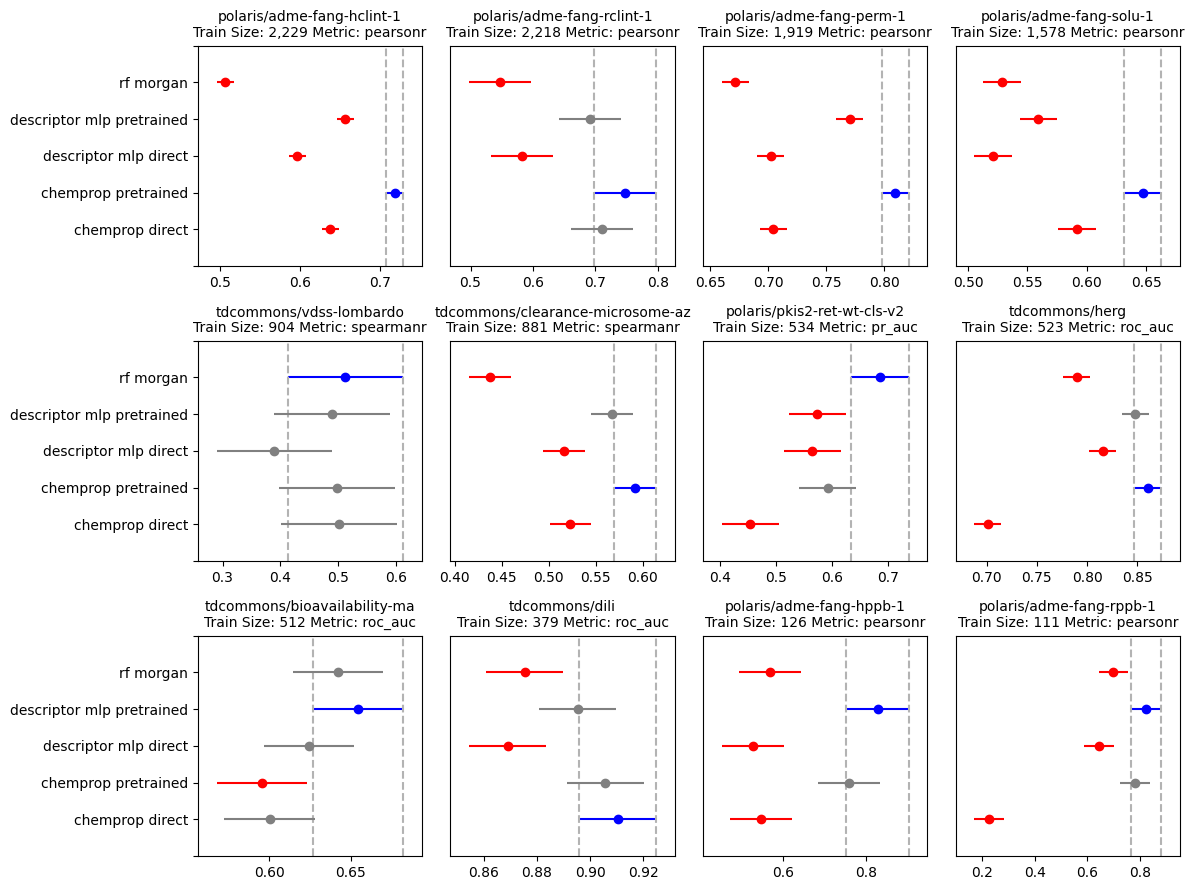

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from collections import defaultdict
from scipy.stats import rankdata

# Prepare to collect ranks
rank_tracker = defaultdict(list)

# Step 2: Group by benchmark, perform Tukey HSD, and collect plotting info
benchmark_groups = df.groupby("benchmark", sort=False)
n_benchmarks = len(benchmark_groups)

ncols = 4
nrows = int(np.ceil(n_benchmarks / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
axes = axes.flatten()

for i, (benchmark, bench_df) in enumerate(benchmark_groups):
    ax = axes[i]
    
    # Run Tukey HSD
    tukey = pairwise_tukeyhsd(bench_df["score"], bench_df["model"])
    
    # Plot Tukey HSD
    comparison_name = bench_df.groupby("model")["score"].mean().idxmax()
    tukey.plot_simultaneous(comparison_name=comparison_name, ax=ax, figsize=(12, 9))
    ax.set_title(benchmark + f"\nTrain Size: {sizes[benchmark]:,} Metric: {metrics[benchmark]}", fontdict=dict(fontsize=10))
    
    # Y-axis label tweaks
    if i % ncols != 0:
        ax.set_yticklabels([])
        ax.set_yticks([])
    else:
        ax.set_yticklabels([name.get_text().replace("_", " ") for name in ax.get_yticklabels()])

    # Calculate dense ranks for this benchmark
    model_means = bench_df.groupby("model")["score"].mean()
    dense_ranks = rankdata(-model_means.values, method="dense")  # negative for descending
    for model, rank in zip(model_means.index, dense_ranks):
        rank_tracker[model].append(rank)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.savefig("test.png", dpi=600)

# Compute average rank across benchmarks
avg_dense_ranks = {model: np.mean(ranks) for model, ranks in rank_tracker.items()}
avg_dense_ranks = pd.Series(avg_dense_ranks).sort_values()

print("\n📊 Average Dense Ranks Across All Benchmarks:")
print(avg_dense_ranks)
